In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load training data

In [3]:
data = pd.read_csv('/content/drive/My Drive/ColabNotebooks/welllog/train.csv', sep=';')

In [4]:
data.head(5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,NaN,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,NaN,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,NaN,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,NaN,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,NaN,NaN,38.495632,160.128342,24.104078,NaN,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


### Inspecting available logs and interpretations

The data contains the metadata columns
* WELL: well name
* DEPTH_MD: measured depth
* X_LOC: UTM X coordinate 
* Y_LOC: UTM Y coordinate
* Z_LOC: DEPTH
* GROUP: NPD lithostratigraphy group
* FORMATION: NPD lithostratgraphy formation

The data contains the well log curves. For example the following:
* BS: Bit Size
* CALI: Caliper
* RDEP: Deep Resistivity
* RHOB: Bulk Density
* GR: Raw gamma data
* SGR: Spectral Gamma Ray
* RMED: Medium Resistivity
* ROP: Rate of Penetration
* NPHI: Neutron Porosity
* PEF: Photoelectric Absorption Factor
* RSHA: Shallow Resistivity
* DTS: Sonic (Sheer Slowness)
* DTC: Sonic (Compressional Slowness)

See contest page for full list.

as well as the interpretation

* FORCE_2020_LITHOFACIES_LITHOLOGY: lithology class label
* FORCE_2020_LITHOFACIES_CONFIDENCE: confidence in lithology interpretation (1: high, 2: medium, 3: low)

There is a total of 83 wells in the training dataset. The `WELL` column is included so the data can be separated per well. This will be necessary for any "windowed" approaches where we use non-local information in the ML features. 

In [5]:
wells = data['WELL'].unique()

In [6]:
wells

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [7]:
len(wells)

98

### The LITHOLOGY column

The LITHOLOGY column contains the interpretation. Each number corresponds to a lithology class, given by the following list:

In [8]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

In [9]:
data['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()

array([65000, 30000, 65030, 70000, 99000, 80000, 86000, 74000, 70032,
       90000, 88000, 93000])

Lithologies are not equally likely. This is reflected in this dataset.

In [10]:
data['FORCE_2020_LITHOFACIES_LITHOLOGY'].shape

(1170511,)

Text(0, 0.5, 'Lithology presence (\\%)')

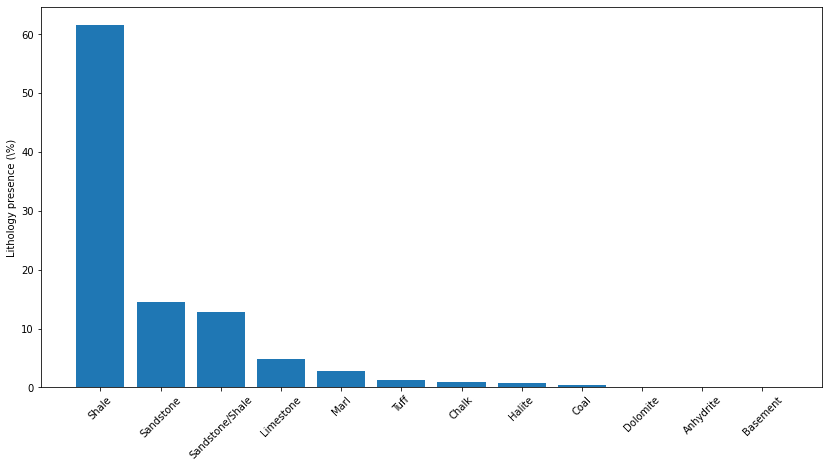

In [11]:
counts = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()
names = []
percentage = []
N = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].shape[0]
for item in counts.iteritems():
    names.append(lithology_keys[item[0]])
    percentage.append(float(item[1])/N*100)
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(len(names)), height=percentage)
ax.set_xticklabels(names, rotation=45)
ax.set_xticks(np.arange(len(names)))
ax.set_ylabel('Lithology presence (\%)')

### Missing logs

**Notice that some of the curves are NaN. This is an imporant aspect of this dataset and of this competition.** The only log columns that are **guaranteed** to be present are WELL, DEPT, and GR. All other logs can (and will) be missing from some parts of the dataset.

In [12]:
data.isna().any()

WELL                                 False
DEPTH_MD                             False
X_LOC                                 True
Y_LOC                                 True
Z_LOC                                 True
GROUP                                 True
FORMATION                             True
CALI                                  True
RSHA                                  True
RMED                                  True
RDEP                                  True
RHOB                                  True
GR                                   False
SGR                                   True
NPHI                                  True
PEF                                   True
DTC                                   True
SP                                    True
BS                                    True
ROP                                   True
DTS                                   True
DCAL                                  True
DRHO                                  True
MUDWEIGHT  

In [13]:
data.isna().sum()

WELL                                       0
DEPTH_MD                                   0
X_LOC                                  10775
Y_LOC                                  10775
Z_LOC                                  10775
GROUP                                   1278
FORMATION                             136994
CALI                                   87877
RSHA                                  539861
RMED                                   38993
RDEP                                   11015
RHOB                                  161269
GR                                         0
SGR                                  1101158
NPHI                                  405102
PEF                                   498819
DTC                                    80863
SP                                    306264
BS                                    487854
ROP                                   635440
DTS                                   995898
DCAL                                  871678
DRHO      

The following plot shows how large a percentage of training data wells contain at least some depth interval with the given logs. As you can see a couple of logs like RT and DTS are present in less than half of the training wells. **Remember, the test data will have a similar distribution of available logs**

In [14]:
data['WELL'].unique()

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [15]:
data[data['WELL'] == '25/6-1'].isna().all().astype(int)

WELL                                 0
DEPTH_MD                             0
X_LOC                                0
Y_LOC                                0
Z_LOC                                0
GROUP                                0
FORMATION                            0
CALI                                 0
RSHA                                 0
RMED                                 0
RDEP                                 0
RHOB                                 0
GR                                   0
SGR                                  1
NPHI                                 0
PEF                                  1
DTC                                  0
SP                                   0
BS                                   0
ROP                                  0
DTS                                  1
DCAL                                 0
DRHO                                 0
MUDWEIGHT                            0
RMIC                                 1
ROPA                     

Text(0, 0.5, 'Well presence (\\%)')

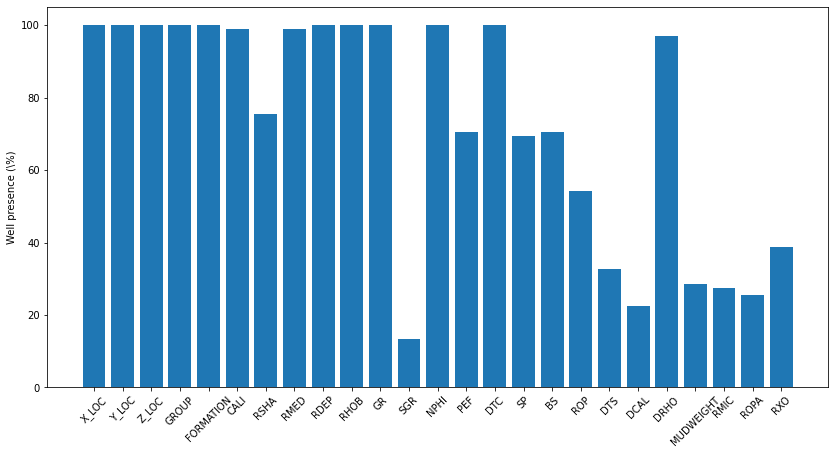

In [16]:
occurences = np.zeros(25)
for well in data['WELL'].unique():
    occurences += data[data['WELL'] == well].isna().all().astype(int).values[2:-2]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(data.WELL.unique().shape[0]-occurences)/data.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(data.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')

#### Look at some log curves for a couple of wells

(3272.0240000000003, 494.528)

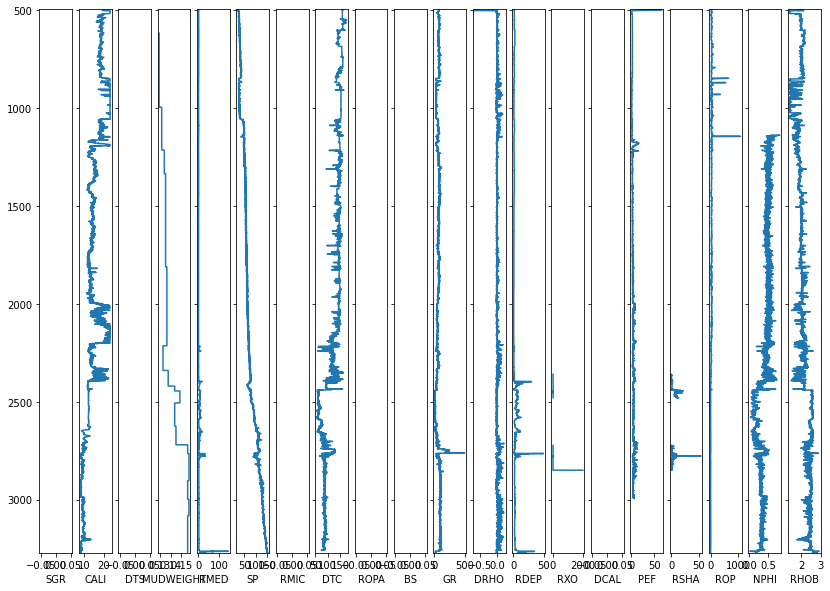

In [17]:
well_data = data[data['WELL'] == wells[0]]
fig, axs = plt.subplots(1, len(well_data.columns)-9, figsize=(14, 10), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
                                                     'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
                                                    'X_LOC', 'Y_LOC', 'Z_LOC'])):
    axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
    axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])

(4422.0172, 2484.1692)

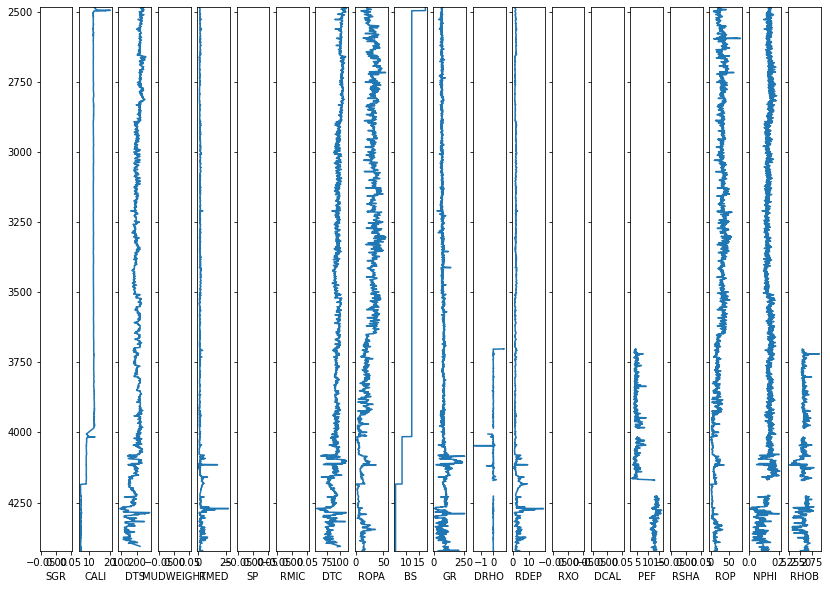

In [18]:
well_data = data[data['WELL'] == wells[57]]
fig, axs = plt.subplots(1, len(well_data.columns)-9, figsize=(14, 10), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
                                                     'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
                                                    'X_LOC', 'Y_LOC', 'Z_LOC'])):
    axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
    axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])

### Preparing data for training

'WELL', 

In [19]:
X = data.drop(columns=['FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE'])

##### As a simple approach we replace nan with zero and hope for the best - НЕ БУДЕМ ИСПОЛЬЗОВАТЬ.

In [20]:
#X.fillna(0, inplace=True)

#### We should convert lithology labels to numbers 0-11 before training

In [21]:
y = data['FORCE_2020_LITHOFACIES_LITHOLOGY']

In [22]:
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

In [23]:
y = y.map(lithology_numbers)

##### Lithologies are not equally likely. Probably smart to take this into account by computing class weights

In [24]:
np.bincount(y)

array([168937, 150455, 720803,  33329,   1688,  56320,  10513,   8213,
         1085,  15245,   3820,    103])

##### Shuffle the data

In [25]:
X, y = shuffle(X, y, random_state=42)

In [26]:
X.head(5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
30423,15/9-15,2343.304000,436806.46875,6463010.5,-2318.007324,ROGALAND GP.,Lista Fm.,14.882113,0.77124,0.771240,0.662699,2.212606,66.807358,NaN,0.399297,3.027709,121.575783,88.208725,12.250001,12.761565,NaN,2.632109,0.115312,0.143792,NaN,NaN,0.57085
1073159,35/3-7 S,3582.467851,543919.75000,6856653.5,-3477.858154,CROMER KNOLL GP.,Roedby Fm.,8.645628,NaN,5.599961,4.988578,2.648031,93.301193,NaN,0.174108,5.034343,63.601940,NaN,8.500000,10.556081,150.206314,NaN,-0.007215,NaN,6.627153,10.410796,NaN
436368,25/9-1,734.814000,483545.34375,6590313.0,-709.762207,NORDLAND GP.,Utsira Fm.,NaN,NaN,NaN,1.000559,NaN,55.920452,NaN,NaN,NaN,NaN,NaN,17.500000,109.271744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290688,25/3-1,1075.968000,487291.25000,6643945.0,-1053.937988,HORDALAND GP.,NaN,17.646826,NaN,0.867609,1.231773,2.044336,41.795280,NaN,NaN,0.772259,148.782700,21.596836,17.500000,7.970956,NaN,0.215513,0.051340,0.958611,NaN,NaN,NaN
1118085,35/9-10 S,3580.061600,537897.75000,6791142.5,-3069.179688,BAAT GP.,Rannoch Fm.,8.572706,NaN,7.634528,8.066478,2.573311,126.820572,NaN,0.257259,3.623197,77.505989,NaN,8.500000,31.773550,140.671463,NaN,0.039784,NaN,NaN,NaN,NaN


#### Select only the columns you want to use

In [27]:
X.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO'],
      dtype='object')

'X_LOC','Y_LOC','Z_LOC'

In [28]:
X = X[['X_LOC','Y_LOC','DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]

# Попробуем восстановить данные

In [29]:
df = X.copy()

In [30]:
df.shape

(1170511, 14)

### Удалим все пропущенные значения и построим матрицу корреляции

In [31]:
df1 = df.dropna().copy()

In [32]:
df_corr = df1.corr()

In [33]:
def color_values(val):
    color = 'red' if ((val > 0.6) or (val < -0.6)) else 'black'
    return 'color: %s' % color

In [34]:
df_corr.style.applymap(color_values)

,X_LOC,Y_LOC,DEPTH_MD,CALI,RSHA,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS
X_LOC,1.000000,0.337725,0.274362,0.016116,0.108256,0.054174,0.048072,0.355730,0.257525,-0.284964,-0.141095,-0.481606,-0.076343,0.101433
Y_LOC,0.337725,1.000000,-0.058132,-0.193210,0.028551,0.008354,0.013219,0.150991,0.194826,-0.152747,0.126640,-0.038844,-0.059312,-0.054124
DEPTH_MD,0.274362,-0.058132,1.000000,-0.518734,0.158066,0.106760,0.091884,0.620450,0.098557,-0.559708,-0.144798,-0.746034,0.245699,-0.589175
CALI,0.016116,-0.193210,-0.518734,1.000000,-0.083529,-0.084481,-0.064702,-0.449604,-0.017215,0.429018,0.052037,0.457414,-0.081734,0.845429
RSHA,0.108256,0.028551,0.158066,-0.083529,1.000000,0.321105,0.198054,0.129462,-0.018707,-0.133807,-0.050348,-0.184784,-0.033140,-0.062239
RMED,0.054174,0.008354,0.106760,-0.084481,0.321105,1.000000,0.270684,0.021581,-0.015373,-0.063450,-0.003798,-0.089100,-0.009261,-0.080228
RDEP,0.048072,0.013219,0.091884,-0.064702,0.198054,0.270684,1.000000,0.036520,0.001008,-0.051919,0.013209,-0.077798,-0.009239,-0.058829
RHOB,0.355730,0.150991,0.620450,-0.449604,0.129462,0.021581,0.036520,1.000000,0.101028,-0.592902,-0.195116,-0.782002,0.095042,-0.336545
GR,0.257525,0.194826,0.098557,-0.017215,-0.018707,-0.015373,0.001008,0.101028,1.000000,0.223127,-0.098942,0.044325,0.045212,-0.015000
NPHI,-0.284964,-0.152747,-0.559708,0.429018,-0.133807,-0.063450,-0.051919,-0.592902,0.223127,1.000000,0.096621,0.733270,-0.373262,0.375041


### Пары корреляции:
1. DEPTH_MD - DTC
2. BS - CALI
3. RHOB - DTC
4. NPHI - DTC

### Визуализируем корреляцию.


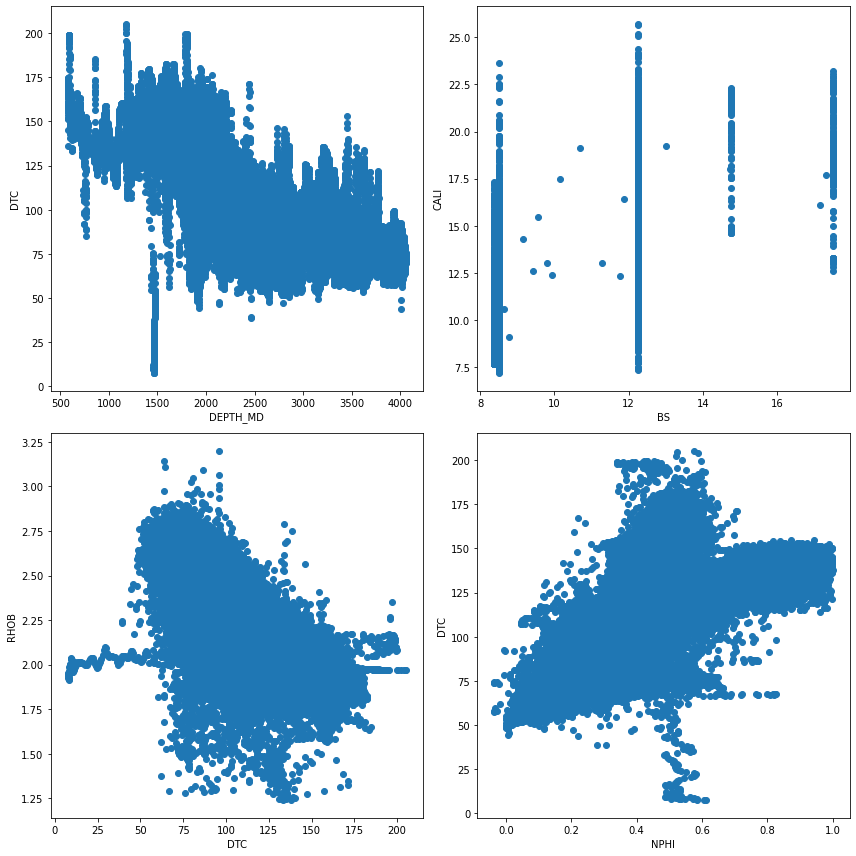

In [35]:
cols = {'DEPTH_MD':'DTC', 'BS':'CALI', 'DTC':'RHOB', 'NPHI':'DTC'}
fig = plt.figure(figsize=(12,12))
for i,j in enumerate(cols.items()):
 fig.add_subplot(2, 2, i+1)
 plt.scatter(df1[j[0]],df1[j[1]])
 plt.xlabel(j[0])
 plt.ylabel(j[1])
 plt.tight_layout()


### Удаляем ненужные переменные для экономии памяти.

In [36]:
del df1, df_corr

### Разделим DEPTH_MD на 5 групп. Для каждой из групп DEPTH_MD заполним соответствующие этой группе пропущенные значения столбца DTC по медиане имеющихся ненулевых значений DTC.

In [37]:
df['DEPTH_GROUP'] = pd.cut(df['DEPTH_MD'],5,labels=[1,2,3,4,5])

In [38]:
dtc_median = 0
for i in df['DEPTH_GROUP'].unique():
  dtc_median = df.loc[df['DTC'].notnull() & (df['DEPTH_GROUP'] == i)]['DTC'].median()
  df.loc[(df['DTC'].isnull() & (df['DEPTH_GROUP'] == i)), 'DTC'] = dtc_median
  print(dtc_median)
del dtc_median

90.879608154
84.012954712
148.72328186
75.69380188
132.634994505


In [39]:
df = df.drop('DEPTH_GROUP', axis = 1)

In [40]:
df['DTC'].isna().sum()

0

### Заполним значения по связке BS - CALI. Сначала пропущенные CALI по имеющимся значениям BS, потом пропущенные BS по имеющимся значениям CALI. Оставшиеся заполним по медиане.



In [41]:
df['BS'].isna().sum()

487854

In [42]:
df['CALI'].isna().sum()

87877

In [43]:
df['BS_GROUP'] = pd.cut(df['BS'],5,labels=[1,2,3,4,5])

In [44]:
cali_median = 0
for i in df['BS_GROUP'].unique():
  cali_median = df.loc[df['CALI'].notnull() & (df['BS_GROUP'] == i)]['CALI'].median()
  df.loc[(df['CALI'].isnull() & (df['BS_GROUP'] == i)), 'CALI'] = cali_median
  print(cali_median)
print('Пропущенных значений CALI -', df['CALI'].isna().sum())
df = df.drop('BS_GROUP', axis = 1)
del cali_median

12.580320358
8.6797008514
18.037179947000002
nan
18.278013229000003
18.290828705
Пропущенных значений CALI - 62965


In [45]:
cali_median = df.loc[df['CALI'].notnull()]['CALI'].median()
df.loc[df['CALI'].isnull(), 'CALI'] = cali_median

In [46]:
print('Пропущенных значений CALI -', df['CALI'].isna().sum())

Пропущенных значений CALI - 0


In [47]:
df['CALI_GROUP'] = pd.cut(df['CALI'],5,labels=[1,2,3,4,5])

In [48]:
df['BS'].isna().sum()

487854

In [49]:
bs_median = 0
for i in df['CALI_GROUP'].unique():
  bs_median = df.loc[df['BS'].notnull() & (df['CALI_GROUP'] == i)]['BS'].median()
  df.loc[(df['BS'].isnull() & (df['CALI_GROUP'] == i)), 'BS'] = bs_median
  print(bs_median)
print('Пропущенных значений BS -', df['BS'].isna().sum())
df = df.drop('CALI_GROUP', axis = 1)
del bs_median

12.250000954
8.5
17.5
6.0
17.5
Пропущенных значений BS - 0


### Следующий на очереди для заполнения столбец RHOB по данным корреляции со столбцом DTC.

In [50]:
df['DTC_GROUP'] = pd.cut(df['DTC'],5,labels=[1,2,3,4,5])
df['DTC_GROUP'].unique()

[2, 1, 3, 4, 5]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [51]:
df['RHOB'].isnull().sum()

161269

In [52]:
rhob_median = 0
for i in df['DTC_GROUP'].unique():
  rhob_median = df.loc[df['RHOB'].notnull() & (df['DTC_GROUP'] == i)]['RHOB'].median()
  df.loc[(df['RHOB'].isnull() & (df['DTC_GROUP'] == i)), 'RHOB'] = rhob_median
  print('Медиана -', rhob_median)
print('Пропущенных значений RHOB -', df['RHOB'].isna().sum())
del rhob_median

Медиана - 2.4135766029
Медиана - 2.59395182135
Медиана - 2.0341788530000002
Медиана - 1.8283954859
Медиана - 1.9220573902
Пропущенных значений RHOB - 0


### Заполняем столбец NPHI по данным корреляции со столбцом DTC.

In [53]:
df['NPHI'].isnull().sum()

405102

In [54]:
nphi_median = 0
for i in df['DTC_GROUP'].unique():
  nphi_median = df.loc[df['NPHI'].notnull() & (df['DTC_GROUP'] == i)]['NPHI'].median()
  df.loc[(df['NPHI'].isnull() & (df['DTC_GROUP'] == i)), 'NPHI'] = nphi_median
  print('Медиана -', nphi_median)
print('Пропущенных значений RHOB -', df['NPHI'].isna().sum())
del nphi_median
df = df.drop('DTC_GROUP', axis = 1)

Медиана - 0.3029362261
Медиана - 0.1137064025
Медиана - 0.4813893139
Медиана - 0.5119898915
Медиана - 0.4797895998
Пропущенных значений RHOB - 0


### Оставшиеся пропущенные значения в других столбцах заполняем по медиане.

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170511 entries, 30423 to 121958
Data columns (total 14 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   X_LOC     1159736 non-null  float64
 1   Y_LOC     1159736 non-null  float64
 2   DEPTH_MD  1170511 non-null  float64
 3   CALI      1170511 non-null  float64
 4   RSHA      630650 non-null   float64
 5   RMED      1131518 non-null  float64
 6   RDEP      1159496 non-null  float64
 7   RHOB      1170511 non-null  float64
 8   GR        1170511 non-null  float64
 9   NPHI      1170511 non-null  float64
 10  PEF       671692 non-null   float64
 11  DTC       1170511 non-null  float64
 12  SP        864247 non-null   float64
 13  BS        1170511 non-null  float64
dtypes: float64(14)
memory usage: 134.0 MB


In [56]:
df.isna().sum()

X_LOC        10775
Y_LOC        10775
DEPTH_MD         0
CALI             0
RSHA        539861
RMED         38993
RDEP         11015
RHOB             0
GR               0
NPHI             0
PEF         498819
DTC              0
SP          306264
BS               0
dtype: int64

In [57]:
  for i in df.columns:
    df.loc[df[i].isnull(),i] = df[i].median()

In [58]:
df.isna().sum()

X_LOC       0
Y_LOC       0
DEPTH_MD    0
CALI        0
RSHA        0
RMED        0
RDEP        0
RHOB        0
GR          0
NPHI        0
PEF         0
DTC         0
SP          0
BS          0
dtype: int64

# Все пропущенные значения заполнены.

In [59]:
X = df.copy()

In [60]:
del df

# Конкатим мета-признаки.

In [61]:
#meta_train=pd.read_csv('/content/drive/My Drive/ColabNotebooks/welllog/train_w_meta.csv')
#meta_train = meta_train.groupby(['WELL','lat','lon','cluster','dist_0','dist_1','dist_2'])['DRHO'].count()
#meta_train = meta_train.reset_index().drop('DRHO',axis=1)

In [62]:
#X = X.merge(meta_train[['WELL','lat','lon','cluster','dist_0','dist_1','dist_2']],how='left',on='WELL')
#X = X.drop('WELL',axis=1)

##### Scale the features

In [63]:
scaler = StandardScaler()

In [64]:
X.columns

Index(['X_LOC', 'Y_LOC', 'DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB',
       'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS'],
      dtype='object')

In [65]:
X = scaler.fit_transform(X)

##### Split into train and test data

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Applying the custom scoring function

Apart from the missing log curves, **one of the key challenges of this machine learning competition is that you are being scored using a custom scoring function**. 

A prediction is scored using the penalty function
$$ S = - \frac{1}{N}\sum_{i=0}^N A_{ \hat{y}_i y_i} $$
where $N$ is the number of samples, $y_i$ is prediction for sample $i$, $\hat{y}_i$ is the true target for sample $i$, and $A$ is the penalty matrix given by the following

In short, the value of the matrix A at row i and column j is the **penalty** given by guessing lithology number i when the correct label is lithology numner j. Notice that the diagonal consists of zeros, no penalty is given for correct predictions.

In [67]:
A = np.load('/content/drive/My Drive/ColabNotebooks/welllog/penalty_matrix.npy')

In [68]:
A

array([[0.   , 2.   , 3.5  , 3.   , 3.75 , 3.5  , 3.5  , 4.   , 4.   ,
        2.5  , 3.875, 3.25 ],
       [2.   , 0.   , 2.375, 2.75 , 4.   , 3.75 , 3.75 , 3.875, 4.   ,
        3.   , 3.75 , 3.   ],
       [3.5  , 2.375, 0.   , 2.   , 3.5  , 3.5  , 3.75 , 4.   , 4.   ,
        2.75 , 3.25 , 3.   ],
       [3.   , 2.75 , 2.   , 0.   , 2.5  , 2.   , 2.25 , 4.   , 4.   ,
        3.375, 3.75 , 3.25 ],
       [3.75 , 4.   , 3.5  , 2.5  , 0.   , 2.625, 2.875, 3.75 , 3.25 ,
        3.   , 4.   , 3.625],
       [3.5  , 3.75 , 3.5  , 2.   , 2.625, 0.   , 1.375, 4.   , 3.75 ,
        3.5  , 4.   , 3.625],
       [3.5  , 3.75 , 3.75 , 2.25 , 2.875, 1.375, 0.   , 4.   , 3.75 ,
        3.125, 4.   , 3.75 ],
       [4.   , 3.875, 4.   , 4.   , 3.75 , 4.   , 4.   , 0.   , 2.75 ,
        3.75 , 3.75 , 4.   ],
       [4.   , 4.   , 4.   , 4.   , 3.25 , 3.75 , 3.75 , 2.75 , 0.   ,
        4.   , 4.   , 3.875],
       [2.5  , 3.   , 2.75 , 3.375, 3.   , 3.5  , 3.125, 3.75 , 4.   ,
        0.   , 2.5  

The scoring function can be implemented as follows. If used as a loss function in a neural network framwork, it is recommended to implement a more efficient function based on tensor products. 

In [69]:
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

**IMPORTANT: The implementation above assumes zero-indexed y_true and y_pred. Be careful not to mix zero-indexed and 1-indexed class labels.**

Let us see what happens when we test the scoring function on some corner cases:

##### Lazily guessing SHALE for everything gives an OK score due to the imbalance of the dataset

In [70]:
score(y_test.values, np.ones(y_test.shape)*2)

-1.154113253567874

##### Doing the same for an uncommon class, like COAL, not so much..

In [71]:
score(y_test.values, np.ones(y_test.shape)*11)

-3.0950906225037698

##### Of course getting it completely right gives the highest possible score, 0

In [72]:
score(y_test.values, y_test.values)

0.0

### Example prediction on open test dataset

##### Train an oversimplified dummy model for the sake of the example
In order to give examples of how to submit predictions and reproducible code, we will train a RandomForestClassifier on the full feature set where we lazily have set all missing values (NaNs) to zero. This is an example only, following along this approach for the competition is not recommended. However, the template below can be used for generating predictions for the weekly leaderboard from your own model, and as an example on how to ecapsulate your model for final scoring where you have to submit code.

Apart from the inherent flaws of the random forest classifier, this example approach has a number of issues and simplifications. For example:
* Data is not separated per well. Normalization and shuffling is done across the whole dataset.
* The penatly matrix is not taken into account, it is treated as a normal classification problem.
* Missing logs are treated as zeros
* Depth and formation tops not taken into account
* Same model is used for when you only have gamma ray logs as when you have the full set of logs

In [73]:
#model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')

In [74]:
#model.fit(X_train, y_train)

# Catboost Classifier

In [75]:
#!pip install catboost
#from catboost import Pool, CatBoostClassifier

In [76]:
#%%time
#acc = pd.DataFrame(columns = ['depth','iterations','scoring'])
#counter = 0
#for i in iterations:
#    for j in depth:
#        cbc = CatBoostClassifier(iterations=i, depth=j, random_state=12345, auto_class_weights='Balanced', task_type="GPU", loss_function='MultiClass')
#        cbc.fit(X_train, y_train, verbose=False, use_best_model=True, eval_set=(X_test,y_test))
#        answers_cbc = cbc.predict(X_test)
#        scoring = score(y_test.values, answers_cbc)
#        acc = acc.append({'iterations':i, 'depth':j,'scoring':scoring}, ignore_index=True)
#        print(counter)
#        counter += 1
#print(acc.sort_values('scoring', ascending=False))

In [77]:
def catbst(x_train,y_train,x_valid,y_valid,iterations,depth,min_data_in_leaf,l2_leaf_reg):
  cbc = CatBoostClassifier(verbose=1000, iterations=iterations, depth=depth, min_data_in_leaf=min_data_in_leaf, l2_leaf_reg=l2_leaf_reg, random_state=12345, auto_class_weights='Balanced', task_type="GPU", loss_function='MultiClass')
  cbc.fit(x_train, y_train, use_best_model=True, eval_set=(x_valid,y_valid))
  scoring = score(y_valid.values,cbc.predict(x_valid))
#  predictions = cbc.predict(x_valid)
  return scoring

In [78]:
#iterations = [3000,5000,6000]
#depth = [2,12]
#min_data_in_leaf = [1,3,5,7]
#l2_leaf_reg = [3,4,5]

In [79]:
#%%time
#acc = pd.DataFrame(columns = ['min_data_in_leaf','l2_leaf_reg','scoring'])
#counter = 0
#for j in min_data_in_leaf:
#  for k in l2_leaf_reg:
#    scoring = catbst(X_train, y_train, X_test, y_test, 6000, 12, j, k)
#    acc = acc.append({'min_data_in_leaf':j,'l2_leaf_reg':k,'scoring':scoring}, ignore_index=True)
#    print(counter,j,k,scoring)
#    counter += 1
#print(acc.sort_values('scoring', ascending=False))

In [80]:
#cbc = CatBoostClassifier(iterations=6000, depth=12, random_state=12345, auto_class_weights='Balanced', task_type="GPU", loss_function='MultiClass').fit(X_train, y_train, verbose=False, use_best_model=True, eval_set=(X_test,y_test))

In [81]:
#open_test_features = pd.read_csv('/content/drive/My Drive/ColabNotebooks/welllog/test.csv', sep=';')
#open_test_features = open_test_features[['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]
#test_prediction = cbc.predict(open_test_features)
#category_to_lithology = {y:x for x,y in lithology_numbers.items()}
#test_prediction_for_submission = np.vectorize(category_to_lithology.get)(test_prediction)
#np.savetxt('/content/drive/My Drive/ColabNotebooks/welllog/test_predictions.csv', test_prediction_for_submission, header='lithology', comments='', fmt='%i')

In [82]:
#score(y_test.values, cbc.predict(X_test))

# KNeighborsClassifier

# RandomForestClassifier

In [83]:
#n_estimators = [150,200,300]
#criterion = ['gini','entropy']
#max_depth = [50,100,150,200]
#min_samples_split = [2,4,6]

In [84]:
#def rfcls(x_train,y_train,x_valid,y_valid,n_estimators,criterion,max_depth,min_samples_split):
#  rfc = clf = RandomForestClassifier(n_jobs=-1,class_weight='balanced',n_estimators=n_estimators,criterion=criterion,max_depth=max_depth,min_samples_split=min_samples_split,random_state=12345)
#  rfc.fit(x_train, y_train)
#  scoring = score(y_valid.values,rfc.predict(x_valid))
#  return scoring

In [85]:
#%%time
#acc = pd.DataFrame(columns = ['n_estimators','criterion','max_depth','min_samples_split','scoring'])
#counter = 0
#for i in n_estimators:
#  for k in criterion:
#    for j in max_depth:
#      for l in min_samples_split:
#        scoring = rfcls(X_train, y_train, X_test, y_test, i, k, j, l)
#        acc = acc.append({'n_estimators':i,'criterion':k,'max_depth':j,'min_samples_split':l,'scoring':scoring}, ignore_index=True)
#        print(counter,i,k,j,l,scoring)
#        counter += 1
#print(acc.sort_values('scoring', ascending=False))

# Заполнение пропусков в тестовой выборке по коррелирующим признакам.

'X_LOC','Y_LOC','Z_LOC'

In [86]:
open_test_features = pd.read_csv('/content/drive/My Drive/ColabNotebooks/welllog/test.csv', sep=';')
open_test_features = open_test_features[['X_LOC','Y_LOC','DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]

In [87]:
df_corr1 = open_test_features.corr()

In [88]:
df_corr1.style.applymap(color_values)

,X_LOC,Y_LOC,DEPTH_MD,CALI,RSHA,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS
X_LOC,1.000000,0.574187,0.259507,-0.383366,-0.013810,0.058584,0.067250,0.415947,0.228556,-0.383473,-0.039975,-0.406902,-0.235953,-0.171042
Y_LOC,0.574187,1.000000,0.426705,-0.146260,-0.004906,0.033817,0.033195,0.469213,0.079297,-0.401943,0.074297,-0.344206,0.599339,-0.098718
DEPTH_MD,0.259507,0.426705,1.000000,-0.677570,0.121664,0.087034,0.077965,0.743819,0.238643,-0.603843,0.005788,-0.821411,0.081675,-0.370914
CALI,-0.383366,-0.146260,-0.677570,1.000000,-0.122744,-0.108787,-0.097690,-0.614240,-0.354648,0.504658,0.200206,0.682103,0.328520,0.930306
RSHA,-0.013810,-0.004906,0.121664,-0.122744,1.000000,0.146633,0.060259,0.141172,0.005853,-0.076066,-0.041636,-0.111403,-0.096819,-0.146758
RMED,0.058584,0.033817,0.087034,-0.108787,0.146633,1.000000,0.754475,0.088654,-0.016858,-0.138611,-0.009938,-0.150901,0.012977,-0.089010
RDEP,0.067250,0.033195,0.077965,-0.097690,0.060259,0.754475,1.000000,0.102719,-0.012948,-0.147344,-0.009539,-0.188168,0.004391,-0.071694
RHOB,0.415947,0.469213,0.743819,-0.614240,0.141172,0.088654,0.102719,1.000000,0.212181,-0.730425,-0.155989,-0.843264,0.079473,-0.281366
GR,0.228556,0.079297,0.238643,-0.354648,0.005853,-0.016858,-0.012948,0.212181,1.000000,0.269841,-0.057580,-0.075719,-0.121179,-0.128281
NPHI,-0.383473,-0.401943,-0.603843,0.504658,-0.076066,-0.138611,-0.147344,-0.730425,0.269841,1.000000,0.037952,0.849490,0.029523,0.197448


# Пары корреляции:
1. BS - CALI  
2. DEPTH_MD - DTC  
3. RHOB - DTC  
4. NPHI - DTC
5. RMED - RDEP

In [89]:
open_test_features.isna().sum()

X_LOC          59
Y_LOC          59
DEPTH_MD        0
CALI         5645
RSHA        97689
RMED          587
RDEP           59
RHOB        16960
GR              0
NPHI        32743
PEF         23283
DTC           823
SP          70159
BS          69822
dtype: int64

# BS - CALI

In [90]:
open_test_features['BS_GROUP'] = pd.cut(open_test_features['BS'],5,labels=[1,2,3,4,5])
cali_median = 0
for i in open_test_features['BS_GROUP'].unique():
  cali_median = open_test_features.loc[open_test_features['CALI'].notnull() & (open_test_features['BS_GROUP'] == i)]['CALI'].median()
  open_test_features.loc[(open_test_features['CALI'].isnull() & (open_test_features['BS_GROUP'] == i)), 'CALI'] = cali_median
  print(i, cali_median)
print('Пропущенных значений CALI -', open_test_features['CALI'].isna().sum())
open_test_features = open_test_features.drop('BS_GROUP', axis = 1)
cali_median = open_test_features.loc[open_test_features['CALI'].notnull()]['CALI'].median()
open_test_features.loc[open_test_features['CALI'].isnull(), 'CALI'] = cali_median
print('Пропущенных значений CALI -', open_test_features['CALI'].isna().sum())
del cali_median

nan nan
5 12.355297565499999
3 12.429699897999999
1 8.5697546005
4 18.7582597735
2 9.54841041565
Пропущенных значений CALI - 5629
Пропущенных значений CALI - 0


In [91]:
open_test_features['CALI_GROUP'] = pd.cut(open_test_features['CALI'],5,labels=[1,2,3,4,5])
bs_median = 0
for i in open_test_features['CALI_GROUP'].unique():
  bs_median = open_test_features.loc[open_test_features['BS'].notnull() & (open_test_features['CALI_GROUP'] == i)]['BS'].median()
  open_test_features.loc[(open_test_features['BS'].isnull() & (open_test_features['CALI_GROUP'] == i)), 'BS'] = bs_median
  print(i, bs_median)
print('Пропущенных значений BS -', open_test_features['BS'].isna().sum())
open_test_features = open_test_features.drop('CALI_GROUP', axis = 1)
del bs_median

4 12.250000954
3 12.250000954
5 17.5
2 12.250000954
1 8.5
Пропущенных значений BS - 0


# DEPTH_MD - DTC

In [92]:
open_test_features['DEPTH_GROUP'] = pd.cut(open_test_features['DEPTH_MD'],5,labels=[1,2,3,4,5])
dtc_median = 0
for i in open_test_features['DEPTH_GROUP'].unique():
  dtc_median = open_test_features.loc[open_test_features['DTC'].notnull() & (open_test_features['DEPTH_GROUP'] == i)]['DTC'].median()
  open_test_features.loc[(open_test_features['DTC'].isnull() & (open_test_features['DEPTH_GROUP'] == i)), 'DTC'] = dtc_median
  print(i, dtc_median)
del dtc_median
print('Пропущенных значений DTC -', open_test_features['DTC'].isna().sum())
open_test_features = open_test_features.drop('DEPTH_GROUP', axis = 1)

1 148.19446563500003
2 136.24996184999998
3 98.7693099975
4 86.146965027
5 86.160392761
Пропущенных значений DTC - 0


# RHOB - DTC

In [93]:
open_test_features['DTC_GROUP'] = pd.cut(open_test_features['DTC'],5,labels=[1,2,3,4,5])
rhob_median = 0
for i in open_test_features['DTC_GROUP'].unique():
  rhob_median = open_test_features.loc[open_test_features['RHOB'].notnull() & (open_test_features['DTC_GROUP'] == i)]['RHOB'].median()
  open_test_features.loc[(open_test_features['RHOB'].isnull() & (open_test_features['DTC_GROUP'] == i)), 'RHOB'] = rhob_median
  print('Медиана -', rhob_median)
print('Пропущенных значений RHOB -', open_test_features['RHOB'].isna().sum())
del rhob_median

Медиана - 1.9828389287000001
Медиана - 2.0659229755
Медиана - 2.3148037195000004
Медиана - 2.5147099495
Медиана - 2.5856499672
Пропущенных значений RHOB - 0


# NPHI - DTC

In [94]:
nphi_median = 0
for i in open_test_features['DTC_GROUP'].unique():
  nphi_median = open_test_features.loc[open_test_features['NPHI'].notnull() & (open_test_features['DTC_GROUP'] == i)]['NPHI'].median()
  open_test_features.loc[(open_test_features['NPHI'].isnull() & (open_test_features['DTC_GROUP'] == i)), 'NPHI'] = nphi_median
  print('Медиана -', nphi_median)
print('Пропущенных значений NPHI -', open_test_features['NPHI'].isna().sum())
del nphi_median
open_test_features = open_test_features.drop('DTC_GROUP', axis = 1)

Медиана - 0.4896999896
Медиана - 0.47349621355000004
Медиана - 0.366350174
Медиана - 0.25383496285
Медиана - 0.1366401017
Пропущенных значений NPHI - 0


# RMED - RDEP

In [95]:
open_test_features.isna().sum()

X_LOC          59
Y_LOC          59
DEPTH_MD        0
CALI            0
RSHA        97689
RMED          587
RDEP           59
RHOB            0
GR              0
NPHI            0
PEF         23283
DTC             0
SP          70159
BS              0
dtype: int64

In [96]:
open_test_features['RDEP_GROUP'] = pd.cut(open_test_features['RDEP'],5,labels=[1,2,3,4,5])
rmed_median = 0
for i in open_test_features['RDEP_GROUP'].unique():
  rmed_median = open_test_features.loc[open_test_features['RMED'].notnull() & (open_test_features['RDEP_GROUP'] == i)]['RMED'].median()
  open_test_features.loc[(open_test_features['RMED'].isnull() & (open_test_features['RDEP_GROUP'] == i)), 'RMED'] = rmed_median
  print(i, rmed_median)
print('Пропущенных значений RMED -', open_test_features['RMED'].isna().sum())
del rmed_median
open_test_features.loc[open_test_features['RMED'].isnull(), 'RMED'] = open_test_features['RMED'].median()
open_test_features = open_test_features.drop('RDEP_GROUP',axis=1)

1 1.6691639423
2 277.177825925
3 255.35612488
4 845.3515319850001
5 1386.9038085999998
nan nan
Пропущенных значений RMED - 59


In [97]:
open_test_features['RMED_GROUP'] = pd.cut(open_test_features['RMED'],5,labels=[1,2,3,4,5])
rmed_median = 0
for i in open_test_features['RMED_GROUP'].unique():
  rmed_median = open_test_features.loc[open_test_features['RDEP'].notnull() & (open_test_features['RMED_GROUP'] == i)]['RDEP'].median()
  open_test_features.loc[(open_test_features['RDEP'].isnull() & (open_test_features['RMED_GROUP'] == i)), 'RDEP'] = rmed_median
  print(i, rmed_median)
print('Пропущенных значений RDEP -', open_test_features['RDEP'].isna().sum())
del rmed_median
open_test_features.loc[open_test_features['RDEP'].isnull(), 'RDEP'] = open_test_features['RDEP'].median()
open_test_features = open_test_features.drop('RMED_GROUP',axis=1)

1 1.65715777875
3 980.94006348
2 305.11828613
5 1073.8111572
4 1284.51953125
Пропущенных значений RDEP - 0


# Модель.

In [98]:
def trainrfc(x_train,y_train,n_estimators,criterion,max_depth,min_samples_split):
  model = RandomForestClassifier(n_jobs=-1,class_weight='balanced',n_estimators=n_estimators,criterion=criterion,max_depth=max_depth,min_samples_split=min_samples_split,random_state=12345)
  model.fit(x_train,y_train)
  return model

In [99]:
def createpred(models,open_test_features):
#  open_test_features = pd.read_csv('/content/drive/My Drive/ColabNotebooks/welllog/test.csv', sep=';')
#  open_test_features = open_test_features[['X_LOC','Y_LOC','DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]
#  open_test_features = open_test_features.merge(meta_train[['WELL','lat','lon','cluster','dist_0','dist_1','dist_2']],how='left',on='WELL')
#  open_test_features = open_test_features.drop('WELL',axis=1)
  for i in open_test_features.columns:
    open_test_features.loc[open_test_features[i].isnull(),i] = open_test_features[i].median()
  open_test_features = scaler.transform(open_test_features)
  test_prediction = models.predict(open_test_features)
  category_to_lithology = {y:x for x,y in lithology_numbers.items()}
  test_prediction_for_submission = np.vectorize(category_to_lithology.get)(test_prediction)
  np.savetxt('/content/drive/My Drive/ColabNotebooks/welllog/test_predictions.csv', test_prediction_for_submission, header='lithology', comments='', fmt='%i')

In [100]:
#def catbst(x_train,y_train,x_valid,y_valid,iterations,depth,min_data_in_leaf,l2_leaf_reg):
#  cbc = CatBoostClassifier(verbose=1000, iterations=iterations, depth=depth, min_data_in_leaf=min_data_in_leaf, l2_leaf_reg=l2_leaf_reg, random_state=12345, auto_class_weights='Balanced', task_type="GPU", loss_function='MultiClass')
#  cbc.fit(x_train, y_train, use_best_model=True, eval_set=(x_valid,y_valid))
#  scoring = score(y_valid.values,cbc.predict(x_valid))
#  predictions = cbc.predict(x_valid)
#  return scoring

# Для валидации.

In [101]:
#model = trainrfc(X_train,y_train,150,'entropy',100,4)

# Для сабмита.

In [102]:
model = trainrfc(X,y,150,'entropy',100,4)

In [103]:
createpred(model,open_test_features)

#### Test model

In [104]:
#y_pred_test = model.predict(X_test)

In [105]:
#score(y_test.values, y_pred_test)

##### Save model and scaler to files

In [106]:
#pickle.dump(model, open('/content/drive/My Drive/ColabNotebooks/welllog/model.pkl', 'wb'))

In [107]:
#pickle.dump(scaler, open('/content/drive/My Drive/ColabNotebooks/welllog/scaler.pkl', 'wb'))

In order to make it easy to run inference on new data, such as the open test dataset, it is recommended to wrap the initialization of the model, all preprocessing steps including normalization, treatment of NaNs and removals of unused columns in a class or pipeline. There are many ways of doing this, one example being a class like below:

In [108]:
class Model(object):
    def __init__(self, model_file, scaler_file):
        # Load pre-trained model from file
        self.model = pickle.load(open(model_file, 'rb'))
        # Load a "pre-trained" scaler from file
        self.scaler = pickle.load(open(scaler_file, 'rb'))
        
    def _preprocess(self, features):
        # Method to be run before inference. Contains things like
        # stripping unwanted columns, replacing NaNs, and scaling 
        # or normalizing data
        features.fillna(0, inplace=True)
        features = features[['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]
        return self.scaler.transform(features)
        
    def predict(self, features):
        # This function should be able to take in features in their
        # raw, unprocessed form as read from the file test.csv and
        # return predictions as an array integers of the same length
        X = self._preprocess(features)
        return self.model.predict(X)

The model can then be initialized using persisted data in the form of saved model file (or models files), scaler files, and other persisted data.  

In [109]:
#model = Model('model.pkl', 'scaler.pkl')

##### Example submission: weekly leaderboard
For the weekly leaderboard that will start September 1st, you are asked to submit predictions on the supplied open dataset in the file `test.csv`. This file contains all the columns that are in the training data except LITHOLOGY and LITHOLOGY_CONFIDENCE. Notice that the test data will also have missing columns. It is therefore important that your inference pipeline has the treatment of these missing columns as part of the pre-processing step.

In [110]:
#open_test_features = pd.read_csv('/content/drive/My Drive/ColabNotebooks/welllog/test.csv', sep=';')

In [111]:
#open_test_features = open_test_features[['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]

**Important:** Before submitting we must map these predictions back to the lithology labels

In [112]:
#category_to_lithology = {y:x for x,y in lithology_numbers.items()}

In [113]:
#test_prediction_for_submission = np.vectorize(category_to_lithology.get)(test_prediction)

For submission to the weekly leaderboard, write the predictions as a csv file
- single column (no index column or similar)
- header: 'lithology'
- exactly the same number of rows as the raw test features
- use the original lithology labels, 65000, 30000, ..., NOT the encoded ones 0, 1, 2, ...

Example:
```
lithology
65000
65000
30000
30000
30000
30000
30000
65030
65030
65030
.
.
.
```

### Submitting code for final scoring
At the end of the competition, the highest performing teams are invited to submit code for blind scoring on a hidden test dataset. The winner will be the team with the best score on the hidden test dataset, not the weekly leaderboard. In order to do this, you must submit the following in a zip-file:
* Code to do the inference
* Any persisted data in the form of pre-trained model or models, scalers, and more
* Information about your environment

There are many ways of doing this. In the example above, the code to do the inference would be the `Model` class in a python-file, the persisted data would be the files `model.pkl` and `scaler.pkl`. 

Your python environment needs to be replicable by the judges of the competition. There are many ways of doing this. Examples include dumping pip package versions to a file

In [114]:
!pip freeze > requirements.txt

If you are using Anaconda, then you can export an envionment file as follows

In [115]:
!conda env export > environment.yml

/bin/bash: conda: command not found


Other options include `Docker`, `pipenv` and many more.